# Deep Learning Models

This is not a deep learning course, but by request, I will introduce simple examples to get started in deep learning and highlight some aspects that I find interesting. In particular, strategies for optimization and specialized architectures are not covered.

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
import tensorflow as tf
import tensorflow.keras as keras

In [5]:
from tensorflow.keras.layers.experimental import preprocessing

In [6]:
from tensorflow.keras.utils import plot_model

In [7]:
import tensorflow_datasets as tfds

## Building models

### Prepare data

In [8]:
(ds_train, ds_val), info = tfds.load(
    'iris',
    split=[
       'train[:70%]',
       'train[70%:]'
    ],
    batch_size=8,
    with_info=True,
    as_supervised=True,
)

In [9]:
for row, label in ds_train.take(1):
    print(row.numpy())
    print(label.numpy())

[[5.1 3.4 1.5 0.2]
 [7.7 3.  6.1 2.3]
 [5.7 2.8 4.5 1.3]
 [6.8 3.2 5.9 2.3]
 [5.2 3.4 1.4 0.2]
 [5.6 2.9 3.6 1.3]
 [5.5 2.6 4.4 1.2]
 [5.5 2.4 3.7 1. ]]
[0 2 1 2 0 1 1 1]


In [10]:
shape = info.features.shape['features']

### Pre-process data

If you need to pre-process your data, see https://keras.io/api/preprocessing/. We will not do any pre-processing for simplicity.

### Sequential API

If the entire pipeline is a single chain of layers, the Sequential API is the simplest to use.

In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, concatenate

#### Set random seed for reproducibility

In [12]:
np.random.seed(0)
tf.random.set_seed(0)

In [13]:
model = Sequential()
model.add(Dense(8, input_shape=shape))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='softmax'))

**Alternative model specification**

```python
model = Sequential(
    Dense(8, input_shape=(4,)),
    Dense(4, activation='relu'),
    Dense(3, activation='softmax')
)
```

In [14]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 15        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [16]:
hist = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=50, 
    verbose=0)

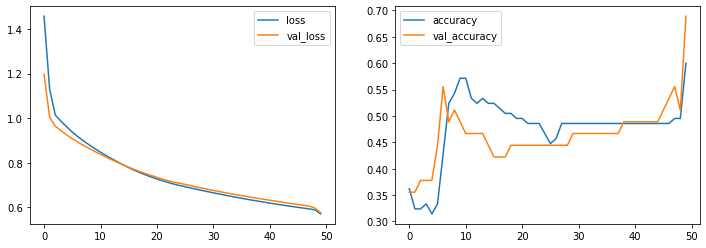

In [17]:
fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure in zip(axes, ['loss', 'accuracy']):
    ax.plot(hist.history[measure], label=measure)
    ax.plot(hist.history['val_' + measure], label='val_' + measure)
    ax.legend()
pass

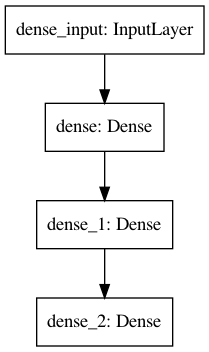

In [18]:
plot_model(model)

### Functional API

The functional API provides flexibility, allowing you to build models with multiple inputs, multiple outputs, or branch and merge architectures.

#### Set random seed for reproducibility

In [19]:
np.random.seed(0)
tf.random.set_seed(0)

In [20]:
input = Input(shape=(4,))
x = Dense(8)(input)
x = Dense(4, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=[input], outputs=[output])

In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 15        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [23]:
hist = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=50, 
    verbose=0)

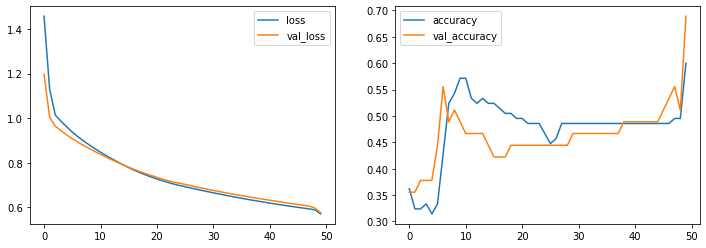

In [24]:
fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure in zip(axes, ['loss', 'accuracy']):
    ax.plot(hist.history[measure], label=measure)
    ax.plot(hist.history['val_' + measure], label='val_' + measure)
    ax.legend()
pass

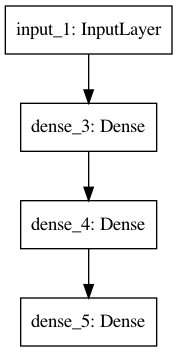

In [25]:
plot_model(model)

#### Flexibility of functional API

You can easily implement multiple inputs, multiple outputs or skip connections. Note that if you have multiple outputs, you probably also want multiple loss functions given as a list in the compile step (unless the same loss function is applicable to both outputs).

In [26]:
input = Input(shape=(4,))
x1 = Dense(8)(input)
x2 = Dense(4, activation='relu')(x1)
x3 = concatenate([input, x2])
output = Dense(3, activation='softmax')(x3)
model = Model(inputs=[input], outputs=[output])

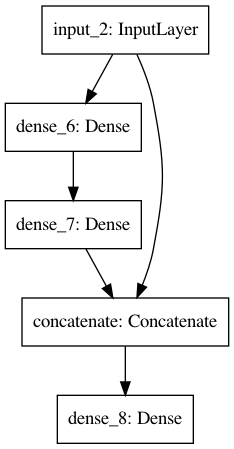

In [27]:
plot_model(model)

## Built-in models and transfer learning

Keras comes with many built-in model architectures that serve as great starting points. Sometimes they even come pre-trained on massive data sets and can be used out-of-the-box, or improved with some transfer learning.

In [28]:
ds, info = tfds.load(name='fashion_mnist', 
                     as_supervised=True, 
                     batch_size=32,
                     with_info=True)

In [29]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

#### Preprocesss the image to make it work InceptionV3

In [30]:
size = [75, 75]
X_train = (ds['train'].
           map(lambda image, label: 
               (tf.image.resize(tf.image.grayscale_to_rgb(image), size), label)))
X_test = (ds['test'].
          map(lambda image, label:
              (tf.image.resize(tf.image.grayscale_to_rgb(image), size), label)))

In [31]:
shape = [item[0].shape for item in X_train.take(1)][0]
shape

TensorShape([32, 75, 75, 3])

In [32]:
base_model = InceptionV3(
    input_shape=shape[1:],
    weights='imagenet', 
    include_top=False,
    classes=10
)

I will plot the model architecture to show why this is *deep* learning.

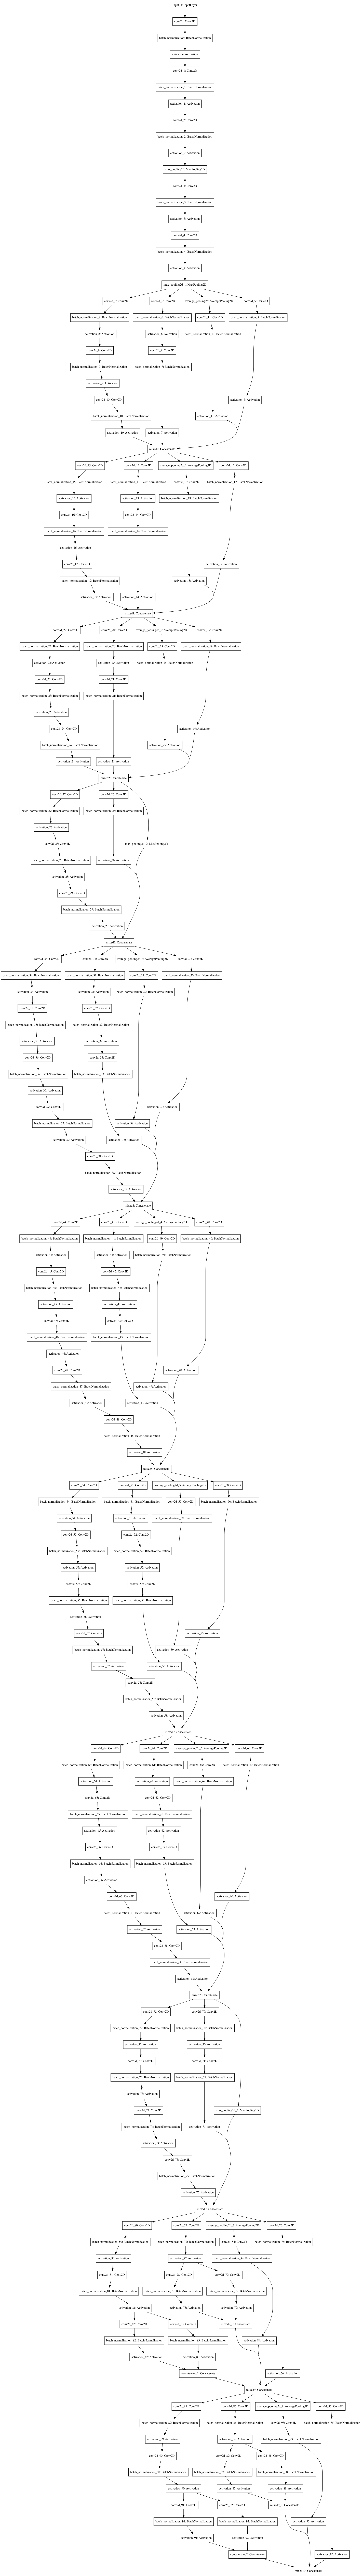

In [33]:
plot_model(base_model)

#### Freeze weights in base model

In [34]:
for layer in base_model.layers:
    layer.trainable = False

#### Add the last layers of the model to predict 10 classes

In [35]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [36]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
model.fit(X_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 160s 85ms/step - loss: 3.3702 - accuracy: 0.6858
Epoch 2/5
1875/1875 [==============================] - 164s 87ms/step - loss: 0.7235 - accuracy: 0.7334
Epoch 3/5
1875/1875 [==============================] - 164s 87ms/step - loss: 0.6897 - accuracy: 0.7462
Epoch 4/5
1875/1875 [==============================] - 163s 87ms/step - loss: 0.6730 - accuracy: 0.7539
Epoch 5/5
1875/1875 [==============================] - 161s 86ms/step - loss: 0.6513 - accuracy: 0.7598


In [38]:
test_loss, test_acc = model.evaluate(X_test)
test_acc

313/313 [==============================] - 25s 81ms/step - loss: 0.6809 - accuracy: 0.7578


0.7577999830245972

## Custom methods

It is not hard to develop custom methods for `keras`, which you might need if you are developing your own methods or want to adapt an existing method from the literature. A few examples are shown to give you an idea of how easy it generally is to write your own custom methods.

### Custom learning rate

In [39]:
def custom_lr(epoch):
    if epoch < 3:
        return 0.001
    else:
        return 0.0001

In [40]:
schedule = keras.callbacks.LearningRateScheduler(custom_lr)

In [41]:
model.fit(X_train, epochs=5, callbacks=[schedule])

Epoch 1/5
1875/1875 [==============================] - 167s 89ms/step - loss: 0.6423 - accuracy: 0.7632
Epoch 2/5
1875/1875 [==============================] - 165s 88ms/step - loss: 0.6312 - accuracy: 0.7697
Epoch 3/5
1875/1875 [==============================] - 172s 91ms/step - loss: 0.6213 - accuracy: 0.7713
Epoch 4/5
1875/1875 [==============================] - 173s 92ms/step - loss: 0.5313 - accuracy: 0.8014
Epoch 5/5
1875/1875 [==============================] - 171s 91ms/step - loss: 0.5198 - accuracy: 0.8047


### Custom loss functions

It is very easy to create a custom loss.

Note: If you need to also save and load a model with a custom loss, you need to wrap it up in a class. See official documentation for details (mostly boilerplate code).

In [42]:
def custom_loss(y_true, y_pred):
    error = y_true - y_pred
    return tf.pow(error, 1.5)

In [43]:
model.compile(
    optimizer='adam',
    loss=custom_loss,
    metrics=['accuracy']
)

### Custom metrics

This is very similar to a loss function. The main difference is that metrics should be human interpretable.

In [44]:
def custom_metric(y_true, y_pred):
    error = y_true - y_pred
    return tf.abs(eror) - 0.5

In [45]:
model.compile(
    optimizer='adam',
    loss=custom_loss,
    metrics=['accuracy', custom_metric]
)

### Custom activation function

In [46]:
def custom_activation(z):
    return tf.math.log(1.0 + tf.exp(z))

In [47]:
layer = Dense(1, activation=custom_activation)

## Hyperparameter optimization

In [48]:
import optuna

In [49]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

In [50]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [51]:
class Objective(object):
    def __init__(self, X, y, 
                 max_epochs, 
                 input_shape, 
                 num_classes):
        self.X = X
        self.y = y
        self.max_epochs = max_epochs
        self.input_shape = input_shape
        self.num_classes = num_classes
 
    def __call__(self, trial):        
        dropout=trial.suggest_discrete_uniform('dropout', 0.05, 0.5, 0.05)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 96, 128])
                      
        params = dict(
            dropout = dropout,
            batch_size = batch_size
        )
            
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=self.input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(params['dropout']))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(params['dropout']))
        model.add(Dense(self.num_classes, activation='softmax'))
            
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])                 
             
        # fit the model
        hist = model.fit(x=self.X, y=self.y,
                          batch_size=params['batch_size'],
                          validation_split=0.25,
                          epochs=self.max_epochs)
                 
        loss = np.min(hist.history['val_loss'])
                 
        return loss

In [52]:
optuna.logging.set_verbosity(0)

In [53]:
N = 5
max_epochs = 3
input_shape = (28,28,1)
num_classes = 10

In [54]:
%%time

objective1 = Objective(X_train, y_train, max_epochs, input_shape, num_classes)
study1 = optuna.create_study(direction='minimize')
study1.optimize(objective1, n_trials=N)

Epoch 1/3
469/469 [==============================] - 31s 67ms/step - loss: 0.2097 - accuracy: 0.9364 - val_loss: 0.0660 - val_accuracy: 0.9805
Epoch 2/3
469/469 [==============================] - 32s 67ms/step - loss: 0.0718 - accuracy: 0.9777 - val_loss: 0.0529 - val_accuracy: 0.9845
Epoch 3/3
469/469 [==============================] - 32s 67ms/step - loss: 0.0487 - accuracy: 0.9845 - val_loss: 0.0474 - val_accuracy: 0.9870
Epoch 1/3
469/469 [==============================] - 32s 67ms/step - loss: 0.1825 - accuracy: 0.9440 - val_loss: 0.0620 - val_accuracy: 0.9815
Epoch 2/3
469/469 [==============================] - 32s 68ms/step - loss: 0.0526 - accuracy: 0.9839 - val_loss: 0.0486 - val_accuracy: 0.9847
Epoch 3/3
469/469 [==============================] - 32s 69ms/step - loss: 0.0324 - accuracy: 0.9897 - val_loss: 0.0480 - val_accuracy: 0.9859
Epoch 1/3
469/469 [==============================] - 33s 70ms/step - loss: 0.1970 - accuracy: 0.9402 - val_loss: 0.0655 - val_accuracy: 0.9803

In [55]:
df = study1.trials_dataframe()

In [56]:
df.head()

number     value             datetime_start          datetime_complete  \
0       0  0.047400 2020-10-21 09:16:39.312276 2020-10-21 09:18:14.498391   
1       1  0.047991 2020-10-21 09:18:14.498431 2020-10-21 09:19:50.615475   
2       2  0.046602 2020-10-21 09:19:50.615512 2020-10-21 09:21:29.444118   
3       3  0.048075 2020-10-21 09:21:29.444156 2020-10-21 09:23:09.047898   
4       4  0.046458 2020-10-21 09:23:09.047937 2020-10-21 09:24:59.744052   

                duration  params_batch_size  params_dropout     state  
0 0 days 00:01:35.186115                 96            0.30  COMPLETE  
1 0 days 00:01:36.117044                 96            0.15  COMPLETE  
2 0 days 00:01:38.828606                 96            0.20  COMPLETE  
3 0 days 00:01:39.603742                 96            0.30  COMPLETE  
4 0 days 00:01:50.696115                 64            0.35  COMPLETE

In [57]:
from optuna.visualization import plot_param_importances

In [58]:
plot_param_importances(study1)

## Interpretable deep learning

This is modeled closely after the example in the official `shap` repository.

In [59]:
import shap

We build a simple model.

In [60]:
num_classes = 10
shape = (28,28,1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [61]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
model.fit(X_train, y_train, epochs=3, verbose=1)

Epoch 1/3
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1834 - accuracy: 0.9443
Epoch 2/3
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0764 - accuracy: 0.9777
Epoch 3/3
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0582 - accuracy: 0.9826


In [63]:
explainer = shap.GradientExplainer(model, X_train)

Using TensorFlow backend.


In [64]:
sv = explainer.shap_values(X_test[:10]);

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [65]:
sv[0].shape

(10, 28, 28, 1)

### Explanations for each class

Red pixels increase the model's output while blue pixels decrease the output. Look where two classes show activation to see how the CNN distinguishes between these outcomes.

In [66]:
model.predict(X_test[:10])

array([[7.07178500e-12, 7.49217755e-09, 1.71038028e-08, 4.51581315e-07,
        5.80331963e-11, 2.27669533e-11, 1.37311706e-14, 9.99999523e-01,
        1.32551539e-10, 1.96453218e-08],
       [9.93617966e-11, 6.05756156e-08, 9.99999881e-01, 3.37476713e-10,
        2.06415701e-11, 1.36300629e-14, 3.36707079e-10, 3.63104602e-10,
        1.93715988e-10, 1.26617618e-12],
       [7.70920394e-08, 9.99906182e-01, 3.65223568e-05, 8.04942886e-08,
        5.29013823e-06, 2.49222785e-06, 5.17479748e-06, 4.14836832e-05,
        2.53988992e-06, 6.95794071e-08],
       [9.99999762e-01, 1.04432386e-10, 2.64277080e-08, 2.05417391e-10,
        2.62160210e-10, 4.47749560e-10, 1.16877509e-07, 2.98726843e-09,
        8.67463523e-09, 6.78320191e-08],
       [1.55436786e-09, 3.09283550e-08, 3.47047759e-08, 4.66938918e-11,
        9.99980092e-01, 1.35004619e-09, 1.24159227e-09, 9.84022748e-08,
        2.08538946e-08, 1.97853424e-05],
       [8.89675444e-09, 9.99972582e-01, 6.71031239e-06, 1.98580921e-08,
   

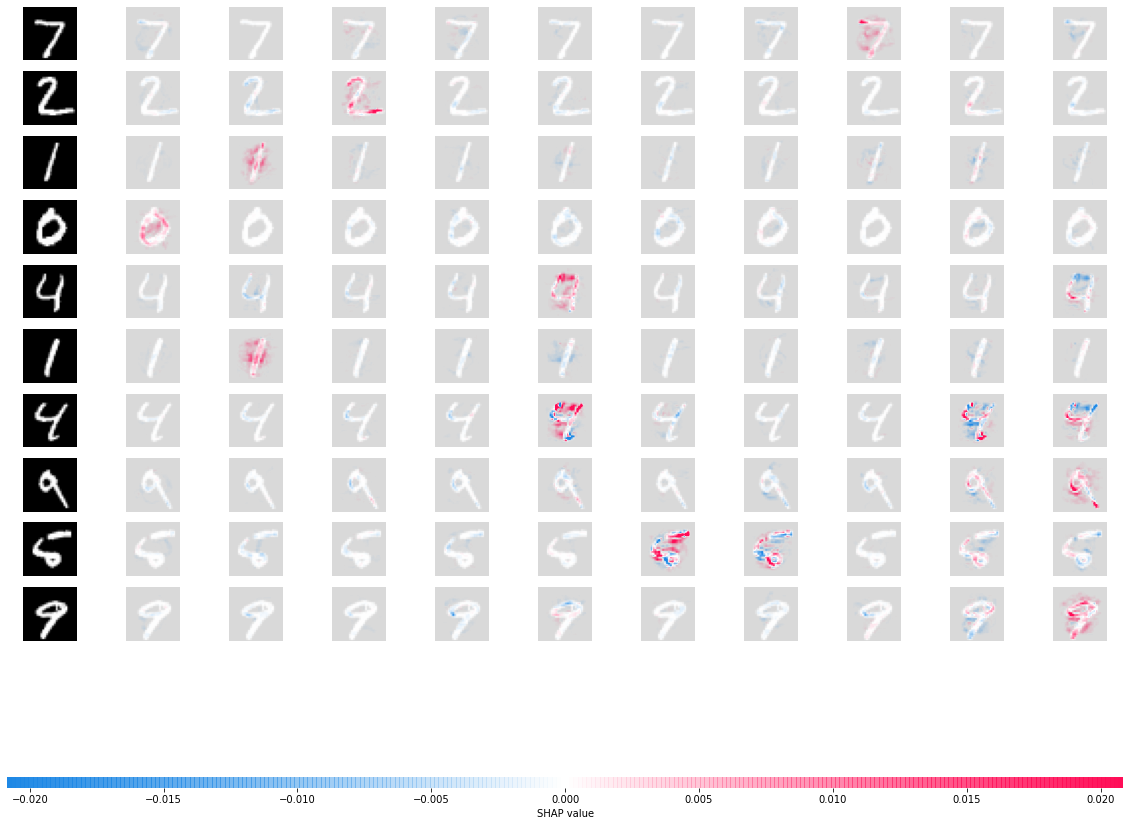

In [67]:
shap.image_plot([sv[i] for i in range(10)], X_test[:10])